In [12]:
!pip install pandas numpy scikit-learn matplotlib seaborn pgmpy dowhy statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import pandas as pd
df = pd.read_excel("/content/Online Retail.xlsx")
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [2]:
df = df.dropna(subset=["CustomerID"])
df = df[df["Country"] == "United Kingdom"]

In [3]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [4]:
df["TotalSales"] = df["Quantity"] * df["UnitPrice"]

In [5]:
df["Week"] = df["InvoiceDate"].dt.to_period("W").apply(lambda r: r.start_time)

In [6]:
weekly_sales = df.groupby("Week")["TotalSales"].sum().reset_index()

In [7]:
weekly_sales.rename(columns={"Week":"date","TotalSales":"sales"}, inplace=True)

In [8]:
import numpy as np
weekly_sales["discount_percent"] = np.random.choice([0, 10, 20], size=len(weekly_sales), p=[0.7, 0.2, 0.1])
weekly_sales["has_discount"] = weekly_sales["discount_percent"] > 0

In [9]:
weekly_sales["campaign_spend"] = np.random.choice([0, 500, 1000], size=len(weekly_sales), p=[0.8, 0.15, 0.05])
weekly_sales["has_campaign"] = weekly_sales["campaign_spend"] > 0

In [10]:
base_price = 25.0
weekly_sales["price"] = base_price * (1 - weekly_sales["discount_percent"] / 100)

In [11]:
weekly_sales["base_price"] = base_price
weekly_sales["week"] = range(1, len(weekly_sales)+1)
weekly_sales["competitor_price"] = base_price * (0.9 + 0.2 * np.random.random(len(weekly_sales)))
weekly_sales["seasonality"] = 1 + 0.3 * np.sin(2 * np.pi * weekly_sales["week"] / 52)
weekly_sales["trend"] = 1 + 0.02 * weekly_sales["week"] / 52
weekly_sales["market_conditions"] = np.random.normal(1, 0.1, len(weekly_sales))
weekly_sales["revenue"] = weekly_sales["sales"] * weekly_sales["price"]
weekly_sales["profit"] = weekly_sales["sales"] * (weekly_sales["price"] - 15) - weekly_sales["campaign_spend"]


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Causal modeling
try:
    from pgmpy.models import DiscreteBayesianNetwork as BayesianNetwork
    from pgmpy.factors.discrete import TabularCPD
    from pgmpy.inference import VariableElimination
    from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
    PGMPY_AVAILABLE = True
except ImportError:
    print("Warning: pgmpy not available. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pgmpy"])
    try:
        from pgmpy.models import DiscreteBayesianNetwork as BayesianNetwork
        from pgmpy.factors.discrete import TabularCPD
        from pgmpy.inference import VariableElimination
        from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
        PGMPY_AVAILABLE = True
    except ImportError:
        PGMPY_AVAILABLE = False
        print("Warning: Could not install pgmpy. Causal graph features will be limited.")

# Time series and ML
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr

In [14]:
class SalesDataGenerator:
    """Generate synthetic sales data with causal relationships"""

    def __init__(self, n_weeks=104, seed=42):
        self.n_weeks = n_weeks
        np.random.seed(seed)

    def generate_data(self):
        """Generate synthetic sales data with realistic causal structure"""
        dates = pd.date_range(start='2022-01-01', periods=self.n_weeks, freq='W')

        data = []
        base_price = 25.0
        base_sales = 100

        for i, date in enumerate(dates):
            week = i + 1

            # Seasonal patterns
            seasonality = 1 + 0.3 * np.sin(2 * np.pi * week / 52)
            trend = 1 + 0.02 * week / 52

            # External factors
            competitor_price = base_price * (0.9 + 0.2 * np.random.random())
            market_conditions = np.random.normal(1, 0.1)

            # Marketing campaign (random events)
            has_campaign = np.random.random() < 0.2
            campaign_spend = np.random.exponential(800) if has_campaign else 0
            campaign_effect = 1 + (campaign_spend / 1000) * 0.1

            # Discount decisions (influenced by competitor price and seasonality)
            discount_probability = 0.1 + 0.2 * (competitor_price < base_price) + 0.1 * (seasonality < 1)
            has_discount = np.random.random() < discount_probability
            discount_percent = np.random.uniform(5, 30) if has_discount else 0

            actual_price = base_price * (1 - discount_percent / 100)

            # Price elasticity effect
            price_elasticity = -1.5
            price_effect = (actual_price / base_price) ** price_elasticity

            # Sales calculation with causal structure
            expected_sales = (base_sales *
                            seasonality *
                            trend *
                            price_effect *
                            campaign_effect *
                            market_conditions)

            # Add noise
            actual_sales = max(0, np.random.normal(expected_sales, expected_sales * 0.1))

            # Revenue and profit
            revenue = actual_sales * actual_price
            cost_per_unit = 15
            profit = actual_sales * (actual_price - cost_per_unit) - campaign_spend

            data.append({
                'date': date,
                'week': week,
                'sales': actual_sales,
                'price': actual_price,
                'base_price': base_price,
                'discount_percent': discount_percent,
                'has_discount': has_discount,
                'campaign_spend': campaign_spend,
                'has_campaign': has_campaign,
                'competitor_price': competitor_price,
                'seasonality': seasonality,
                'trend': trend,
                'revenue': revenue,
                'profit': profit,
                'market_conditions': market_conditions
            })

        return pd.DataFrame(data)


In [15]:
class CausalGraphBuilder:
    """Build and analyze causal graphs for sales data"""

    def __init__(self):
        self.model = None
        self.inference = None

    def build_sales_causal_graph(self, data):
        """Build causal graph representing sales relationships"""

        if not PGMPY_AVAILABLE:
            print("Warning: pgmpy not available. Using simplified causal analysis.")
            return self._build_simple_causal_model(data)

        # Define causal structure
        # Competitor Price -> Discount Decision
        # Seasonality -> Discount Decision
        # Discount -> Price -> Sales
        # Campaign -> Sales
        # Market Conditions -> Sales
        # Past Sales -> Current Sales (temporal)

        # Create discretized versions for Bayesian Network
        df_discrete = self._discretize_variables(data)

        try:
            # Define the causal graph structure
            model = BayesianNetwork([
                ('competitor_price_cat', 'discount_cat'),
                ('seasonality_cat', 'discount_cat'),
                ('discount_cat', 'price_cat'),
                ('price_cat', 'sales_cat'),
                ('campaign_cat', 'sales_cat'),
                ('market_cat', 'sales_cat'),
                ('past_sales_cat', 'sales_cat')
            ])

            # Fit the model
            model.fit(df_discrete, estimator=MaximumLikelihoodEstimator)

            self.model = model
            self.inference = VariableElimination(model)

            return model
        except Exception as e:
            print(f"Error building Bayesian Network: {e}")
            return self._build_simple_causal_model(data)

    def _discretize_variables(self, data):
        """Convert continuous variables to categorical for Bayesian Network"""
        df = data.copy()

        # Add lagged sales
        df['past_sales'] = df['sales'].shift(1).fillna(df['sales'].mean())

        # Discretize variables
        df['competitor_price_cat'] = pd.cut(df['competitor_price'],
                                          bins=3, labels=['low', 'medium', 'high'])
        df['seasonality_cat'] = pd.cut(df['seasonality'],
                                     bins=3, labels=['low', 'medium', 'high'])
        df['discount_cat'] = pd.cut(df['discount_percent'],
                                  bins=[-0.1, 0, 15, 100], labels=['none', 'low', 'high'])
        df['price_cat'] = pd.cut(df['price'],
                               bins=3, labels=['low', 'medium', 'high'])
        df['sales_cat'] = pd.cut(df['sales'],
                               bins=3, labels=['low', 'medium', 'high'])
        df['campaign_cat'] = pd.cut(df['campaign_spend'],
                                  bins=[-0.1, 0, 500, np.inf], labels=['none', 'low', 'high'])
        df['market_cat'] = pd.cut(df['market_conditions'],
                                bins=3, labels=['poor', 'average', 'good'])
        df['past_sales_cat'] = pd.cut(df['past_sales'],
                                    bins=3, labels=['low', 'medium', 'high'])

        # Convert to strings (required by pgmpy)
        categorical_cols = [col for col in df.columns if col.endswith('_cat')]
        for col in categorical_cols:
            df[col] = df[col].astype(str)

        return df[categorical_cols]

    def _build_simple_causal_model(self, data):
        """Build simplified causal model using correlation analysis"""
        print("Building simplified causal model using statistical correlations...")

        # Calculate key relationships
        causal_relationships = {}

        # Discount -> Sales relationship
        discount_sales_corr = data['discount_percent'].corr(data['sales'])
        causal_relationships['discount_to_sales'] = discount_sales_corr

        # Campaign -> Sales relationship
        campaign_sales_corr = data['campaign_spend'].corr(data['sales'])
        causal_relationships['campaign_to_sales'] = campaign_sales_corr

        # Price -> Sales relationship
        price_sales_corr = data['price'].corr(data['sales'])
        causal_relationships['price_to_sales'] = price_sales_corr

        # Competitor price -> Discount decision
        comp_discount_corr = data['competitor_price'].corr(data['discount_percent'])
        causal_relationships['competitor_to_discount'] = comp_discount_corr

        self.simple_model = causal_relationships
        return causal_relationships

    def analyze_causal_effects(self, data):
        """Analyze causal effects using the built graph"""
        if not PGMPY_AVAILABLE or self.model is None:
            return self._analyze_simple_causal_effects(data)

        results = {}

        # Query: Effect of discount on sales
        try:
            # P(Sales=high | Discount=high)
            prob_high_sales_with_discount = self.inference.query(
                variables=['sales_cat'],
                evidence={'discount_cat': 'high'}
            )

            # P(Sales=high | Discount=none)
            prob_high_sales_no_discount = self.inference.query(
                variables=['sales_cat'],
                evidence={'discount_cat': 'none'}
            )

            results['discount_effect'] = {
                'with_discount': prob_high_sales_with_discount,
                'without_discount': prob_high_sales_no_discount
            }

        except Exception as e:
            print(f"Error in causal analysis: {e}")
            return self._analyze_simple_causal_effects(data)

        return results

    def _analyze_simple_causal_effects(self, data):
        """Simplified causal effect analysis using statistical methods"""
        results = {}

        # Compare sales with and without discounts
        discount_data = data[data['has_discount'] == True]
        no_discount_data = data[data['has_discount'] == False]

        if len(discount_data) > 0 and len(no_discount_data) > 0:
            # T-test for difference in means
            t_stat, p_value = stats.ttest_ind(discount_data['sales'], no_discount_data['sales'])

            results['discount_effect'] = {
                'with_discount_mean': discount_data['sales'].mean(),
                'without_discount_mean': no_discount_data['sales'].mean(),
                'difference': discount_data['sales'].mean() - no_discount_data['sales'].mean(),
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            }

        # Campaign effect analysis
        campaign_data = data[data['has_campaign'] == True]
        no_campaign_data = data[data['has_campaign'] == False]

        if len(campaign_data) > 0 and len(no_campaign_data) > 0:
            t_stat_camp, p_value_camp = stats.ttest_ind(campaign_data['sales'], no_campaign_data['sales'])

            results['campaign_effect'] = {
                'with_campaign_mean': campaign_data['sales'].mean(),
                'without_campaign_mean': no_campaign_data['sales'].mean(),
                'difference': campaign_data['sales'].mean() - no_campaign_data['sales'].mean(),
                't_statistic': t_stat_camp,
                'p_value': p_value_camp,
                'significant': p_value_camp < 0.05
            }

        return results

In [16]:
class SalesForecastingModel:
    """Advanced forecasting model with causal features"""

    def __init__(self):
        self.models = {}
        self.feature_importance = {}
        self.metrics = {}

    def prepare_features(self, data):
        """Engineer features for forecasting"""
        df = data.copy()
        df = df.sort_values('date').reset_index(drop=True)

        # Lag features
        for lag in [1, 2, 4, 8]:
            df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
            df[f'discount_lag_{lag}'] = df['discount_percent'].shift(lag)

        # Rolling statistics
        for window in [4, 8, 12]:
            df[f'sales_ma_{window}'] = df['sales'].rolling(window).mean()
            df[f'sales_std_{window}'] = df['sales'].rolling(window).std()
            df[f'discount_ma_{window}'] = df['discount_percent'].rolling(window).mean()

        # Time features
        df['month'] = df['date'].dt.month
        df['quarter'] = df['date'].dt.quarter
        df['week_of_year'] = df['date'].dt.isocalendar().week

        # Interaction features
        df['price_discount_interaction'] = df['price'] * df['discount_percent']
        df['campaign_discount_interaction'] = df['campaign_spend'] * df['discount_percent']

        # Price elasticity proxy
        df['price_change'] = df['price'].pct_change()
        df['sales_change'] = df['sales'].pct_change()

        # Fill NaN values
        df = df.fillna(method='bfill').fillna(0)

        return df

    def train_ensemble_model(self, data, target_col='sales', test_size=0.2):
        """Train ensemble of forecasting models"""

        # Prepare features
        df = self.prepare_features(data)
        df = df.dropna()

        # Feature selection
        feature_cols = [col for col in df.columns if col not in
                       ['date', 'sales', 'revenue', 'profit'] or col.startswith('sales_')]
        feature_cols = [col for col in feature_cols if not col.startswith('sales_lag_1')]  # Avoid target leakage

        X = df[feature_cols]
        y = df[target_col]

        # Train-test split (temporal)
        split_idx = int(len(df) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Train multiple models
        models = {
            'random_forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'gradient_boost': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'linear': LinearRegression()
        }

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            self.models[name] = model
            self.metrics[name] = {
                'mae': mean_absolute_error(y_test, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'mape': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            }

            # Feature importance for tree-based models
            if hasattr(model, 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'feature': X.columns,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                self.feature_importance[name] = importance_df

        # Ensemble prediction (simple average)
        ensemble_pred = np.mean([model.predict(X_test) for model in models.values()], axis=0)
        self.metrics['ensemble'] = {
            'mae': mean_absolute_error(y_test, ensemble_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, ensemble_pred)),
            'mape': np.mean(np.abs((y_test - ensemble_pred) / y_test)) * 100
        }

        return X_train, X_test, y_train, y_test

    def forecast_with_intervention(self, data, intervention_params, n_periods=4):
        """Forecast sales with specified interventions"""

        # Prepare data
        df = self.prepare_features(data)
        feature_cols = [col for col in df.columns if col not in
                       ['date', 'sales', 'revenue', 'profit'] or col.startswith('sales_')]

        forecasts = {}

        for model_name, model in self.models.items():
            if model_name == 'ensemble':
                continue

            predictions = []
            current_data = df.iloc[-1:].copy()

            for period in range(n_periods):
                # Apply intervention
                current_data['discount_percent'] = intervention_params.get('discount_percent', 0)
                current_data['campaign_spend'] = intervention_params.get('campaign_spend', 0)

                # Update time features
                last_date = current_data['date'].iloc[0]
                next_date = last_date + timedelta(weeks=1)
                current_data['date'] = next_date
                current_data['month'] = next_date.month
                current_data['quarter'] = next_date.quarter
                current_data['week_of_year'] = next_date.isocalendar().week

                # Predict
                X_pred = current_data[feature_cols]
                # Handle any remaining NaN values
                X_pred = X_pred.fillna(method='bfill').fillna(method='ffill').fillna(0)
                pred = model.predict(X_pred)[0]
                predictions.append(pred)

                # Update for next iteration
                current_data['sales'] = pred
                # Use pandas concat instead of deprecated append
                temp_data = pd.concat([df.tail(10), current_data], ignore_index=True)
                current_data = self.prepare_features(temp_data).iloc[-1:]

            forecasts[model_name] = predictions

        # Ensemble forecast
        ensemble_forecast = np.mean(list(forecasts.values()), axis=0)
        forecasts['ensemble'] = ensemble_forecast

        return forecasts

In [17]:
class CounterfactualAnalyzer:
    """Perform counterfactual analysis for causal inference"""

    def __init__(self, forecasting_model):
        self.forecasting_model = forecasting_model

    def estimate_counterfactual_sales(self, data, actual_intervention, counterfactual_intervention, n_periods=4):
        """Estimate what would have happened under different intervention"""

        # Forecast with actual intervention
        actual_forecast = self.forecasting_model.forecast_with_intervention(
            data, actual_intervention, n_periods
        )

        # Forecast with counterfactual intervention
        counterfactual_forecast = self.forecasting_model.forecast_with_intervention(
            data, counterfactual_intervention, n_periods
        )

        # Calculate causal impact
        causal_impact = {}
        for model_name in actual_forecast.keys():
            actual_sales = np.array(actual_forecast[model_name])
            counterfactual_sales = np.array(counterfactual_forecast[model_name])

            impact = actual_sales - counterfactual_sales
            relative_impact = impact / counterfactual_sales * 100

            causal_impact[model_name] = {
                'absolute_impact': impact,
                'relative_impact': relative_impact,
                'total_impact': np.sum(impact),
                'average_impact': np.mean(relative_impact)
            }

        return {
            'actual_forecast': actual_forecast,
            'counterfactual_forecast': counterfactual_forecast,
            'causal_impact': causal_impact
        }

    def sensitivity_analysis(self, data, base_intervention, parameter_ranges, n_periods=4):
        """Perform sensitivity analysis on intervention parameters"""

        results = {}

        for param_name, param_range in parameter_ranges.items():
            param_results = []

            for param_value in param_range:
                intervention = base_intervention.copy()
                intervention[param_name] = param_value

                forecast = self.forecasting_model.forecast_with_intervention(
                    data, intervention, n_periods
                )

                total_sales = np.sum(forecast['ensemble'])
                param_results.append({
                    'parameter_value': param_value,
                    'total_forecasted_sales': total_sales,
                    'forecast': forecast['ensemble']
                })

            results[param_name] = param_results

        return results

In [18]:
class SalesAnalysisReporter:
    """Generate comprehensive analysis reports"""

    def __init__(self):
        self.figures = []

    def plot_sales_trends(self, data):
        """Plot sales trends and patterns"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Sales over time
        axes[0,0].plot(data['date'], data['sales'])
        axes[0,0].set_title('Sales Over Time')
        axes[0,0].set_xlabel('Date')
        axes[0,0].set_ylabel('Sales')

        # Discount impact
        discount_data = data[data['has_discount'] == True]
        no_discount_data = data[data['has_discount'] == False]

        axes[0,1].hist([discount_data['sales'], no_discount_data['sales']],
                      bins=20, alpha=0.7, label=['With Discount', 'No Discount'])
        axes[0,1].set_title('Sales Distribution by Discount')
        axes[0,1].set_xlabel('Sales')
        axes[0,1].legend()

        # Price vs Sales scatter
        colors = data['discount_percent']
        scatter = axes[1,0].scatter(data['price'], data['sales'], c=colors, cmap='viridis')
        axes[1,0].set_title('Price vs Sales (colored by discount %)')
        axes[1,0].set_xlabel('Price')
        axes[1,0].set_ylabel('Sales')
        plt.colorbar(scatter, ax=axes[1,0])

        # Campaign effect
        campaign_data = data[data['has_campaign'] == True]
        no_campaign_data = data[data['has_campaign'] == False]

        axes[1,1].boxplot([campaign_data['sales'], no_campaign_data['sales']],
                         labels=['With Campaign', 'No Campaign'])
        axes[1,1].set_title('Sales by Campaign Status')
        axes[1,1].set_ylabel('Sales')

        plt.tight_layout()
        self.figures.append(fig)
        return fig

    def plot_forecast_results(self, actual_data, forecasts, intervention_params):
        """Plot forecasting results"""
        fig, ax = plt.subplots(figsize=(12, 6))

        # Historical data
        ax.plot(actual_data['date'], actual_data['sales'],
               label='Historical Sales', color='blue', linewidth=2)

        # Forecast periods
        last_date = actual_data['date'].max()
        forecast_dates = pd.date_range(start=last_date + timedelta(weeks=1),
                                     periods=len(forecasts['ensemble']), freq='W')

        # Plot different model forecasts
        colors = ['red', 'green', 'orange', 'purple']
        for i, (model_name, forecast) in enumerate(forecasts.items()):
            ax.plot(forecast_dates, forecast,
                   label=f'{model_name.title()} Forecast',
                   color=colors[i % len(colors)],
                   linestyle='--', marker='o')

        ax.set_title(f'Sales Forecast\nDiscount: {intervention_params.get("discount_percent", 0)}%, Campaign: ${intervention_params.get("campaign_spend", 0)}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        self.figures.append(fig)
        return fig

    def plot_counterfactual_analysis(self, counterfactual_results):
        """Plot counterfactual analysis results"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        actual = counterfactual_results['actual_forecast']['ensemble']
        counterfactual = counterfactual_results['counterfactual_forecast']['ensemble']
        impact = counterfactual_results['causal_impact']['ensemble']['absolute_impact']

        periods = range(1, len(actual) + 1)

        # Sales comparison
        width = 0.35
        x = np.arange(len(periods))

        axes[0].bar(x - width/2, actual, width, label='With Intervention', alpha=0.8)
        axes[0].bar(x + width/2, counterfactual, width, label='Without Intervention', alpha=0.8)
        axes[0].set_title('Actual vs Counterfactual Sales')
        axes[0].set_xlabel('Period')
        axes[0].set_ylabel('Sales')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels([f'Week {p}' for p in periods])
        axes[0].legend()

        # Causal impact
        colors = ['green' if i > 0 else 'red' for i in impact]
        axes[1].bar(periods, impact, color=colors, alpha=0.7)
        axes[1].set_title('Causal Impact (Actual - Counterfactual)')
        axes[1].set_xlabel('Period')
        axes[1].set_ylabel('Sales Impact')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].set_xticks(periods)
        axes[1].set_xticklabels([f'Week {p}' for p in periods])

        plt.tight_layout()
        self.figures.append(fig)
        return fig

    def generate_summary_report(self, data, model_metrics, causal_results, counterfactual_results):
        """Generate a comprehensive summary report"""

        print("="*60)
        print("CAUSAL IMPACT ANALYSIS - SALES & DISCOUNTS")
        print("="*60)

        # Data Summary
        print("\n📊 DATA SUMMARY")
        print("-" * 30)
        print(f"Total weeks analyzed: {len(data)}")
        print(f"Average weekly sales: {data['sales'].mean():.1f}")
        print(f"Average discount rate: {data['discount_percent'].mean():.1f}%")
        print(f"Weeks with discounts: {data['has_discount'].sum()} ({data['has_discount'].mean()*100:.1f}%)")
        print(f"Total campaign spend: ${data['campaign_spend'].sum():.0f}")

        # Statistical relationships
        discount_correlation = data['sales'].corr(data['discount_percent'])
        price_correlation = data['sales'].corr(data['price'])
        campaign_correlation = data['sales'].corr(data['campaign_spend'])

        print(f"\n📈 KEY CORRELATIONS")
        print("-" * 30)
        print(f"Sales vs Discount %: {discount_correlation:.3f}")
        print(f"Sales vs Price: {price_correlation:.3f}")
        print(f"Sales vs Campaign Spend: {campaign_correlation:.3f}")

        # Model Performance
        print(f"\n🎯 MODEL PERFORMANCE")
        print("-" * 30)
        for model_name, metrics in model_metrics.items():
            print(f"{model_name.upper()}:")
            print(f"  MAE: {metrics['mae']:.2f}")
            print(f"  RMSE: {metrics['rmse']:.2f}")
            print(f"  MAPE: {metrics['mape']:.2f}%")

        # Causal Impact Summary
        if counterfactual_results:
            impact = counterfactual_results['causal_impact']['ensemble']
            print(f"\n🎲 CAUSAL IMPACT ANALYSIS")
            print("-" * 30)
            print(f"Total impact: {impact['total_impact']:.1f} units")
            print(f"Average weekly impact: {impact['average_impact']:.1f}%")
            print(f"Impact range: {impact['absolute_impact'].min():.1f} to {impact['absolute_impact'].max():.1f}")

        # Business Insights
        print(f"\n💼 BUSINESS INSIGHTS")
        print("-" * 30)

        # Calculate ROI metrics
        discount_weeks = data[data['has_discount'] == True]
        no_discount_weeks = data[data['has_discount'] == False]

        if len(discount_weeks) > 0 and len(no_discount_weeks) > 0:
            avg_sales_with_discount = discount_weeks['sales'].mean()
            avg_sales_without_discount = no_discount_weeks['sales'].mean()
            sales_lift = (avg_sales_with_discount - avg_sales_without_discount) / avg_sales_without_discount * 100

            print(f"Average sales lift from discounts: {sales_lift:.1f}%")
            print(f"Average profit with discounts: ${discount_weeks['profit'].mean():.0f}")
            print(f"Average profit without discounts: ${no_discount_weeks['profit'].mean():.0f}")

        print(f"\n🔮 RECOMMENDATIONS")
        print("-" * 30)
        if discount_correlation > 0:
            print("✅ Discounts show positive correlation with sales")
        else:
            print("⚠️  Discounts show negative correlation with sales - review strategy")

        if campaign_correlation > 0.1:
            print("✅ Marketing campaigns are effective")
        else:
            print("⚠️  Marketing campaigns show limited effectiveness")

In [19]:
class SalesAnalysisReporter:
    """Generate comprehensive analysis reports"""

    def __init__(self):
        self.figures = []

    def plot_sales_trends(self, data):
        """Plot sales trends and patterns"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Sales over time
        axes[0,0].plot(data['date'], data['sales'])
        axes[0,0].set_title('Sales Over Time')
        axes[0,0].set_xlabel('Date')
        axes[0,0].set_ylabel('Sales')

        # Discount impact
        discount_data = data[data['has_discount'] == True]
        no_discount_data = data[data['has_discount'] == False]

        axes[0,1].hist([discount_data['sales'], no_discount_data['sales']],
                      bins=20, alpha=0.7, label=['With Discount', 'No Discount'])
        axes[0,1].set_title('Sales Distribution by Discount')
        axes[0,1].set_xlabel('Sales')
        axes[0,1].legend()

        # Price vs Sales scatter
        colors = data['discount_percent']
        scatter = axes[1,0].scatter(data['price'], data['sales'], c=colors, cmap='viridis')
        axes[1,0].set_title('Price vs Sales (colored by discount %)')
        axes[1,0].set_xlabel('Price')
        axes[1,0].set_ylabel('Sales')
        plt.colorbar(scatter, ax=axes[1,0])

        # Campaign effect
        campaign_data = data[data['has_campaign'] == True]
        no_campaign_data = data[data['has_campaign'] == False]

        axes[1,1].boxplot([campaign_data['sales'], no_campaign_data['sales']],
                         labels=['With Campaign', 'No Campaign'])
        axes[1,1].set_title('Sales by Campaign Status')
        axes[1,1].set_ylabel('Sales')

        plt.tight_layout()
        self.figures.append(fig)
        return fig

    def plot_forecast_results(self, actual_data, forecasts, intervention_params):
        """Plot forecasting results"""
        fig, ax = plt.subplots(figsize=(12, 6))

        # Historical data
        ax.plot(actual_data['date'], actual_data['sales'],
               label='Historical Sales', color='blue', linewidth=2)

        # Forecast periods
        last_date = actual_data['date'].max()
        forecast_dates = pd.date_range(start=last_date + timedelta(weeks=1),
                                     periods=len(forecasts['ensemble']), freq='W')

        # Plot different model forecasts
        colors = ['red', 'green', 'orange', 'purple']
        for i, (model_name, forecast) in enumerate(forecasts.items()):
            ax.plot(forecast_dates, forecast,
                   label=f'{model_name.title()} Forecast',
                   color=colors[i % len(colors)],
                   linestyle='--', marker='o')

        ax.set_title(f'Sales Forecast\nDiscount: {intervention_params.get("discount_percent", 0)}%, Campaign: ${intervention_params.get("campaign_spend", 0)}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        self.figures.append(fig)
        return fig

    def plot_counterfactual_analysis(self, counterfactual_results):
        """Plot counterfactual analysis results"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        actual = counterfactual_results['actual_forecast']['ensemble']
        counterfactual = counterfactual_results['counterfactual_forecast']['ensemble']
        impact = counterfactual_results['causal_impact']['ensemble']['absolute_impact']

        periods = range(1, len(actual) + 1)

        # Sales comparison
        width = 0.35
        x = np.arange(len(periods))

        axes[0].bar(x - width/2, actual, width, label='With Intervention', alpha=0.8)
        axes[0].bar(x + width/2, counterfactual, width, label='Without Intervention', alpha=0.8)
        axes[0].set_title('Actual vs Counterfactual Sales')
        axes[0].set_xlabel('Period')
        axes[0].set_ylabel('Sales')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels([f'Week {p}' for p in periods])
        axes[0].legend()

        # Causal impact
        colors = ['green' if i > 0 else 'red' for i in impact]
        axes[1].bar(periods, impact, color=colors, alpha=0.7)
        axes[1].set_title('Causal Impact (Actual - Counterfactual)')
        axes[1].set_xlabel('Period')
        axes[1].set_ylabel('Sales Impact')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].set_xticks(periods)
        axes[1].set_xticklabels([f'Week {p}' for p in periods])

        plt.tight_layout()
        self.figures.append(fig)
        return fig

    def generate_summary_report(self, data, model_metrics, causal_results, counterfactual_results):
        """Generate a comprehensive summary report"""

        print("="*60)
        print("CAUSAL IMPACT ANALYSIS - SALES & DISCOUNTS")
        print("="*60)

        # Data Summary
        print("\n📊 DATA SUMMARY")
        print("-" * 30)
        print(f"Total weeks analyzed: {len(data)}")
        print(f"Average weekly sales: {data['sales'].mean():.1f}")
        print(f"Average discount rate: {data['discount_percent'].mean():.1f}%")
        print(f"Weeks with discounts: {data['has_discount'].sum()} ({data['has_discount'].mean()*100:.1f}%)")
        print(f"Total campaign spend: ${data['campaign_spend'].sum():.0f}")

        # Statistical relationships
        discount_correlation = data['sales'].corr(data['discount_percent'])
        price_correlation = data['sales'].corr(data['price'])
        campaign_correlation = data['sales'].corr(data['campaign_spend'])

        print(f"\n📈 KEY CORRELATIONS")
        print("-" * 30)
        print(f"Sales vs Discount %: {discount_correlation:.3f}")
        print(f"Sales vs Price: {price_correlation:.3f}")
        print(f"Sales vs Campaign Spend: {campaign_correlation:.3f}")

        # Model Performance
        print(f"\n🎯 MODEL PERFORMANCE")
        print("-" * 30)
        for model_name, metrics in model_metrics.items():
            print(f"{model_name.upper()}:")
            print(f"  MAE: {metrics['mae']:.2f}")
            print(f"  RMSE: {metrics['rmse']:.2f}")
            print(f"  MAPE: {metrics['mape']:.2f}%")

        # Causal Impact Summary
        if counterfactual_results:
            impact = counterfactual_results['causal_impact']['ensemble']
            print(f"\n🎲 CAUSAL IMPACT ANALYSIS")
            print("-" * 30)
            print(f"Total impact: {impact['total_impact']:.1f} units")
            print(f"Average weekly impact: {impact['average_impact']:.1f}%")
            print(f"Impact range: {impact['absolute_impact'].min():.1f} to {impact['absolute_impact'].max():.1f}")

        # Business Insights
        print(f"\n💼 BUSINESS INSIGHTS")
        print("-" * 30)

        # Calculate ROI metrics
        discount_weeks = data[data['has_discount'] == True]
        no_discount_weeks = data[data['has_discount'] == False]

        if len(discount_weeks) > 0 and len(no_discount_weeks) > 0:
            avg_sales_with_discount = discount_weeks['sales'].mean()
            avg_sales_without_discount = no_discount_weeks['sales'].mean()
            sales_lift = (avg_sales_with_discount - avg_sales_without_discount) / avg_sales_without_discount * 100

            print(f"Average sales lift from discounts: {sales_lift:.1f}%")
            print(f"Average profit with discounts: ${discount_weeks['profit'].mean():.0f}")
            print(f"Average profit without discounts: ${no_discount_weeks['profit'].mean():.0f}")

        # Display causal insights if available
        if causal_results and isinstance(causal_results, dict):
            if 'discount_effect' in causal_results:
                effect = causal_results['discount_effect']
                if 'difference' in effect:
                    print(f"Causal discount effet: {effect['difference']:.1f} units")
                    if effect.get('significant', False):
                        print("✅ Discount effect is statistically significant")
                    else:
                        print("⚠️  Discount effect is not statistically significant")

        print(f"\n🔮 RECOMMENDATIONS")
        print("-" * 30)
        if discount_correlation > 0:
            print("✅ Discounts show positive correlation with sales")
        else:
            print("⚠️  Discounts show negative correlation with sales - review strategy")

        if campaign_correlation > 0.1:
            print("✅ Marketing campaigns are effective")
        else:
            print("⚠️  Marketing campaigns show limited effectiveness")

def install_requirements():
    """Install required packages"""
    required_packages = [
        'pandas', 'numpy', 'scikit-learn', 'matplotlib', 'seaborn',
        'statsmodels', 'scipy'
    ]

    import subprocess
    import sys

    for package in required_packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

Initializing Causal Sales Analysis...
Installing scikit-learn...

1. Generating synthetic sales data...
Generated 53 weeks of sales data

2. Building causal graph...
Causal analysis completed successfully

3. Training forecasting models...
Forecasting models trained successfully

4. Performing counterfactual analysis...
Error in counterfactual analysis: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- sales_lag_1


5. Running sensitivity analysis...
Error in sensitivity analysis: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- sales_lag_1


6. Generating analysis reports...


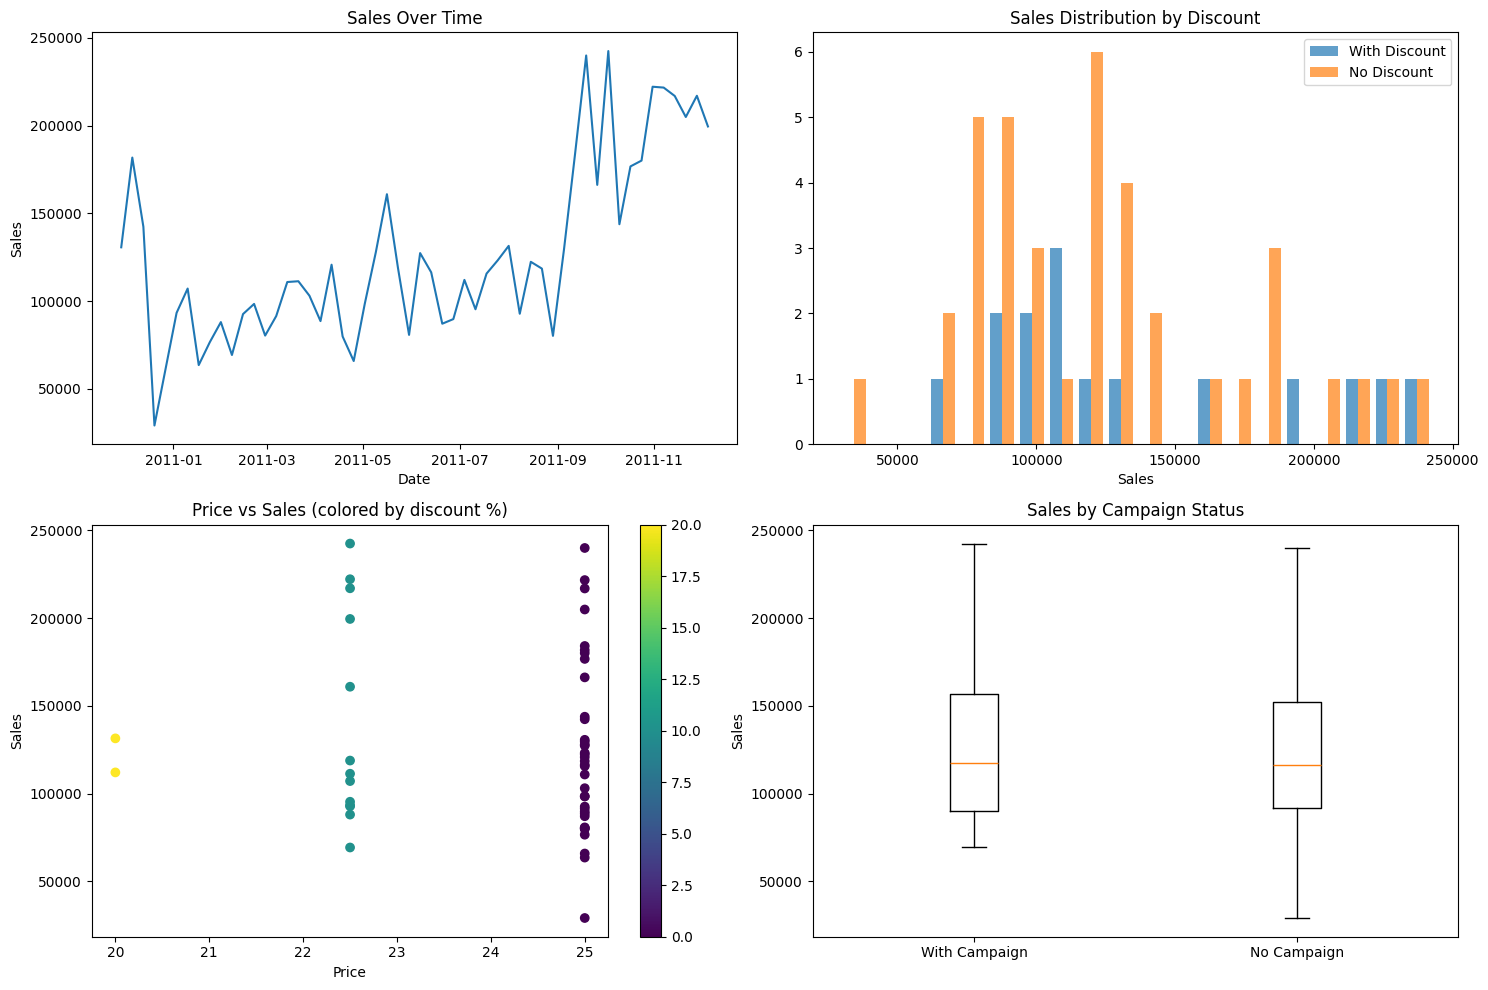

Error generating plots: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- sales_lag_1

CAUSAL IMPACT ANALYSIS - SALES & DISCOUNTS

📊 DATA SUMMARY
------------------------------
Total weeks analyzed: 53
Average weekly sales: 127695.7
Average discount rate: 3.2%
Weeks with discounts: 15 (28.3%)
Total campaign spend: $7500

📈 KEY CORRELATIONS
------------------------------
Sales vs Discount %: 0.093
Sales vs Price: -0.093
Sales vs Campaign Spend: 0.046

🎯 MODEL PERFORMANCE
------------------------------
RANDOM_FOREST:
  MAE: 32364.78
  RMSE: 34850.91
  MAPE: 16.07%
GRADIENT_BOOST:
  MAE: 25565.30
  RMSE: 28005.44
  MAPE: 12.53%
LINEAR:
  MAE: 177634.51
  RMSE: 206764.50
  MAPE: 87.45%
ENSEMBLE:
  MAE: 54822.70
  RMSE: 58777.29
  MAPE: 27.66%

💼 BUSINESS INSIGHTS
------------------------------
Average sales lift from discounts: 11.0%
Average profit with discounts: $989913
Average profit without discounts: $1238434

🔮 RECOMMENDATIONS
-----

In [20]:
def main():
    """Main execution function"""
    print("Initializing Causal Sales Analysis...")

    # Install requirements if needed
    try:
        install_requirements()
    except Exception as e:
        print(f"Warning: Could not install some requirements: {e}")

    # 1. Generate synthetic data
    print("\n1. Generating synthetic sales data...")
    # data_generator = SalesDataGenerator(n_weeks=104)
    # data = data_generator.generate_data()
    data = weekly_sales
    print(f"Generated {len(data)} weeks of sales data")

    # 2. Build causal graph
    print("\n2. Building causal graph...")
    causal_builder = CausalGraphBuilder()
    causal_model = causal_builder.build_sales_causal_graph(data)
    causal_effects = causal_builder.analyze_causal_effects(data)
    print("Causal analysis completed successfully")

    # 3. Train forecasting models
    print("\n3. Training forecasting models...")
    forecasting_model = SalesForecastingModel()
    try:
        X_train, X_test, y_train, y_test = forecasting_model.train_ensemble_model(data)
        print("Forecasting models trained successfully")
    except Exception as e:
        print(f"Error training models: {e}")
        return None

    # 4. Perform counterfactual analysis
    print("\n4. Performing counterfactual analysis...")
    counterfactual_analyzer = CounterfactualAnalyzer(forecasting_model)


    # Define intervention scenarios
    actual_intervention = {'discount_percent': 20, 'campaign_spend': 1000}
    counterfactual_intervention = {'discount_percent': 0, 'campaign_spend': 0}

    try:
        counterfactual_results = counterfactual_analyzer.estimate_counterfactual_sales(
            data, actual_intervention, counterfactual_intervention, n_periods=4
        )
    except Exception as e:
        print(f"Error in counterfactual analysis: {e}")
        counterfactual_results = None

    # 5. Sensitivity analysis
    print("\n5. Running sensitivity analysis...")
    try:
        sensitivity_results = counterfactual_analyzer.sensitivity_analysis(
            data,
            {'discount_percent': 15, 'campaign_spend': 500},
            {
                'discount_percent': np.arange(0, 31, 5),
                'campaign_spend': np.arange(0, 2001, 250)
            }
        )
    except Exception as e:
        print(f"Error in sensitivity analysis: {e}")
        sensitivity_results = None

    # 6. Generate reports and visualizations
    print("\n6. Generating analysis reports...")
    reporter = SalesAnalysisReporter()

    try:
        # Plot trends
        fig1 = reporter.plot_sales_trends(data)
        plt.show()

        # Plot forecasts
        forecast_sample = forecasting_model.forecast_with_intervention(
            data, actual_intervention, n_periods=4
        )
        fig2 = reporter.plot_forecast_results(data, forecast_sample, actual_intervention)
        plt.show()

        # Plot counterfactual analysis if available
        if counterfactual_results:
            fig3 = reporter.plot_counterfactual_analysis(counterfactual_results)
            plt.show()

    except Exception as e:
        print(f"Error generating plots: {e}")

    # Generate summary report
    try:
        reporter.generate_summary_report(
            data,
            forecasting_model.metrics,
            causal_effects,
            counterfactual_results
        )
    except Exception as e:
        print(f"Error generating summary: {e}")

    print("\n✅ Analysis complete!")

    return {
        'data': data,
        'causal_model': causal_model,
        'forecasting_model': forecasting_model,
        'counterfactual_results': counterfactual_results,
        'sensitivity_results': sensitivity_results
    }

if __name__ == "__main__":
    results = main()